# 📷 Cifar-10 Image Classification

El conjunto de datos `CIFAR-10` consta de `60000` imágenes en color `32x32` en `10` clases, con `6000` imágenes por clase. Hay "50000" imágenes de entrenamiento y "10000" imágenes de prueba.

# 🔬 Definición del problema:

Dada una imagen, ¿podemos predecir la clase correcta de esta imagen?

Las imágenes son muy pequeñas (`32x32`) y al visualizarlas notarás lo difícil que es distinguirlas incluso para un humano.

En este cuaderno vamos a construir un modelo CNN que puede clasificar imágenes de varios objetos. Tenemos clase `10` de imágenes:
1. Avión
2. automóvil
3. pájaro
4. gato
5. ciervo
6. perro
7. rana
8. caballo
9. barco
10. camión

In [1]:
import pandas as pd
import numpy as np
import pickle, os, sys
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix

# 📥 Load the data

In [2]:
# Función para desempaquetar los archivos
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Función para convertir los datos planos en imágenes de 32x32x3
def unpack_image(data, index):
    image = data[index].reshape(3, 32, 32).transpose(1, 2, 0)
    return image

def imgTo1D(img):
    resultado = []
    for i in img:
        for j in i:
            resultado.append(np.mean(j))
    return np.asarray(resultado).reshape(1, 32, 32).transpose(1, 2, 0)

def add_speckle_noise(image, noise_level):
    # Generar ruido speckle
    noise = noise_level * np.random.randn(*image.shape)
    noisy_image = image + image * noise
    noisy_image = np.clip(noisy_image, 0, 255)  # Asegurar que los valores de píxel sigan siendo válidos
    return noisy_image.astype(np.uint8)

In [3]:
# Lista para almacenar los datos
batches = []

# Update the data_dir path to the correct directory path
data_dir = os.path.join('../../01_data', 'cifar-10-batches-py')

# Cargar cada archivo en la carpeta
for filename in os.listdir(data_dir):
    if filename.startswith('data_batch'):
        file_path = os.path.join(data_dir, filename)
        print(filename)
        data_dict = unpickle(file_path)
        batches.append(data_dict)

# Ahora 'data' es una lista con todas las imágenes del conjunto de datos
print(f'Número total de batches procesados: {len(batches)}')

# Extraer la data y las etiquetas
data_train = np.vstack([batch[b'data'] for batch in batches])
labels_train = np.hstack([batch[b'labels'] for batch in batches])

data_batch_1
data_batch_2
data_batch_5
data_batch_4
data_batch_3
Número total de batches procesados: 5


In [4]:
# Lista para almacenar los datos
batches = []

# Update the data_dir path to the correct directory path
data_dir = os.path.join('../../01_data', 'cifar-10-batches-py')

# Cargar cada archivo en la carpeta
for filename in os.listdir(data_dir):
    if filename.startswith('data_test'):
        file_path = os.path.join(data_dir, filename)
        print(filename)
        data_dict = unpickle(file_path)
        batches.append(data_dict)

# Ahora 'data' es una lista con todas las imágenes del conjunto de datos
print(f'Número total de batches procesados: {len(batches)}')

# Extraer la data y las etiquetas
data_test = np.vstack([batch[b'data'] for batch in batches])
labels_test = np.hstack([batch[b'labels'] for batch in batches])

data_test_batch
Número total de batches procesados: 1


In [5]:
images1D_train = []
for i, img in enumerate(data_train):
    resultadoImgTo1D = imgTo1D(unpack_image(data_train, i))
    images1D_train.append(resultadoImgTo1D)
images1D_train = np.array(images1D_train)    

images1D_test = []
for i, img in enumerate(data_test):
    resultadoImgTo1D = imgTo1D(unpack_image(data_test, i))
    images1D_test.append(resultadoImgTo1D)
images1D_test = np.array(images1D_test)    

In [6]:
data_medium_noisy_train = []
label_medium_noisy_train = []
data_medium_noisy_test = []
label_medium_noisy_test = []


# Generar ruido speckle para todas las imágenes
for i, image in enumerate(images1D_train):
    noisy_image_medium = add_speckle_noise(imgTo1D(images1D_train[i]), 1)
    label_medium_noisy_train = labels_train[i]

    data_medium_noisy_train.append(noisy_image_medium)
data_medium_noisy_train = np.array(data_medium_noisy_train)

for i, image in enumerate(images1D_test):
    noisy_image_medium = add_speckle_noise(imgTo1D(images1D_test[i]), 1)
    label_medium_noisy_test = labels_test[i]

    data_medium_noisy_test.append(noisy_image_medium)
data_medium_noisy_test = np.array(data_medium_noisy_test)

In [7]:
X_train = data_medium_noisy_train
X_test = data_medium_noisy_test
y_train = np.array(labels_train)
y_test = np.array(labels_test)

In [8]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (50000, 32, 32, 1)
y_train shape: (50000,)
X_test shape: (10000, 32, 32, 1)
y_test shape: (10000,)


# 🖼 Data Visualization

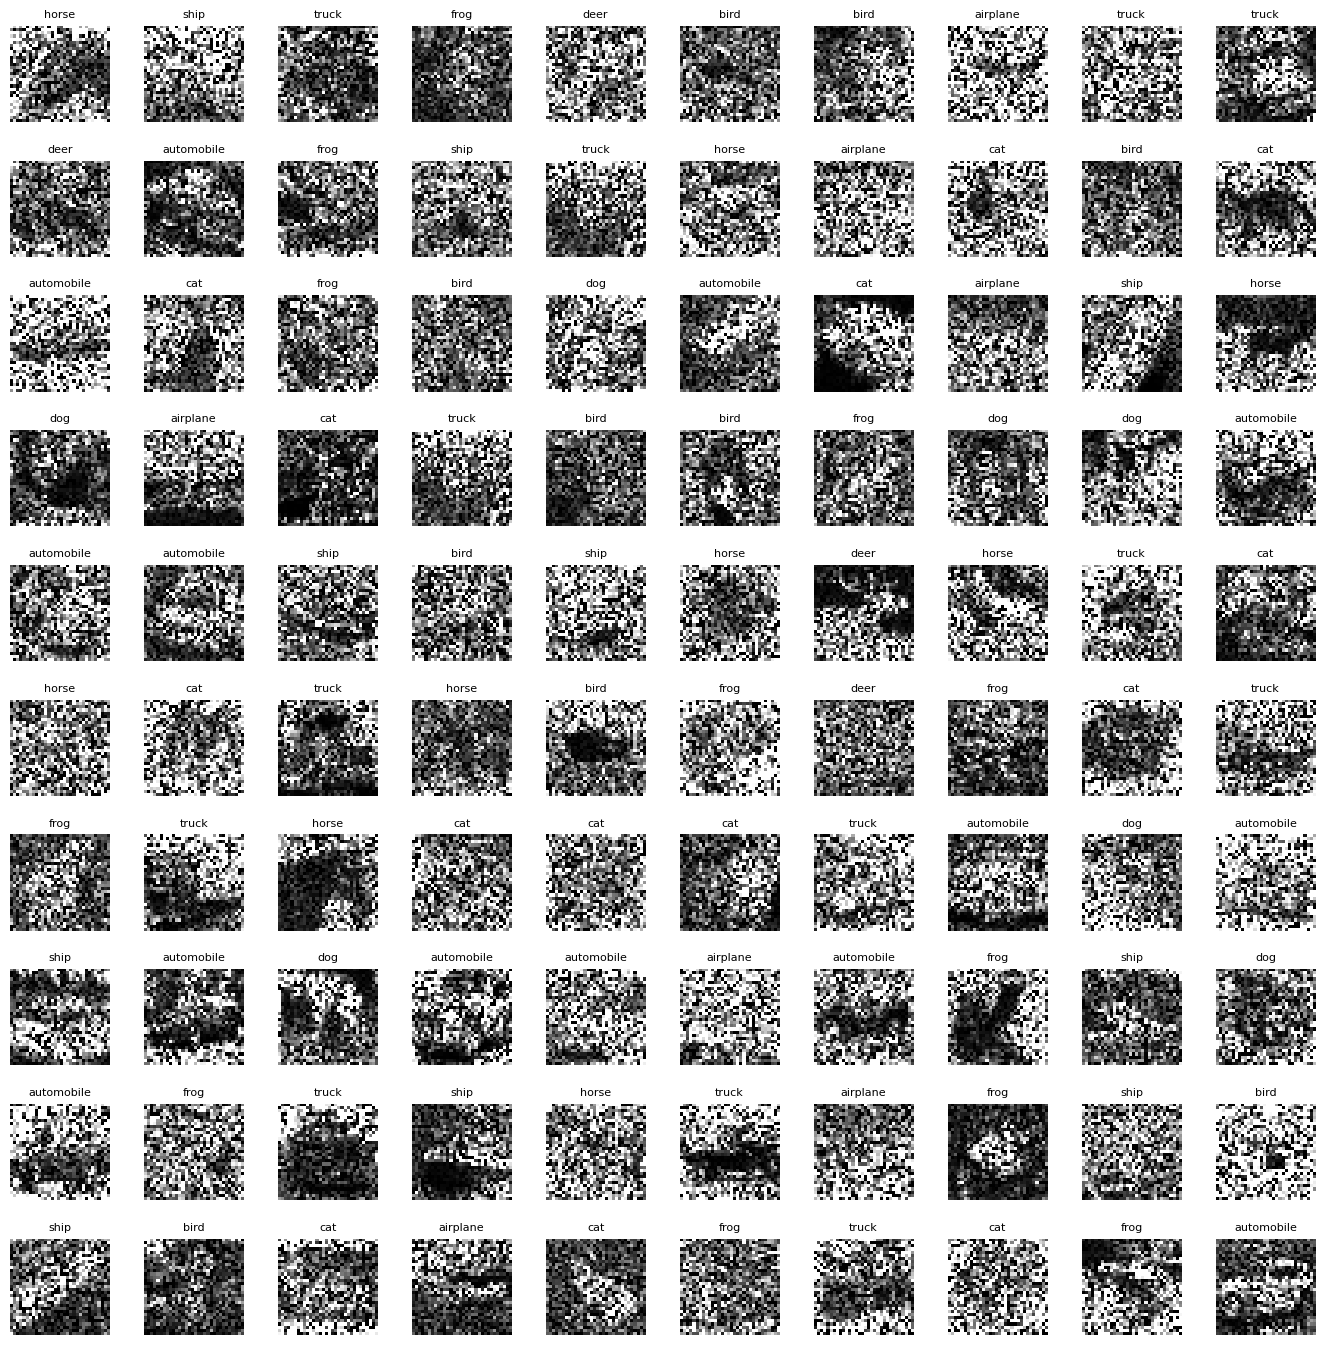

In [9]:
# Define the labels of the dataset
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
          'dog', 'frog', 'horse', 'ship', 'truck']

# Let's view more images in a grid format
# Define the dimensions of the plot grid 
W_grid = 10
L_grid = 10

# fig, axes = plt.subplots(L_grid, W_grid)
# subplot return the figure object and axes object
# we can use the axes object to plot specific figures at various locations

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))

axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array

n_train = len(X_train) # get the length of the train dataset

# Select a random number from 0 to n_train
for i in np.arange(0, W_grid * L_grid): # create evenly spaces variables 

    # Select a random number
    index = np.random.randint(0, n_train)
    # read and display an image with the selected index    
    axes[i].imshow(X_train[index,1:], cmap='gray')
    label_index = int(y_train[index])
    axes[i].set_title(labels[label_index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

Text(0.5, 1.0, 'Class distribution in training set')

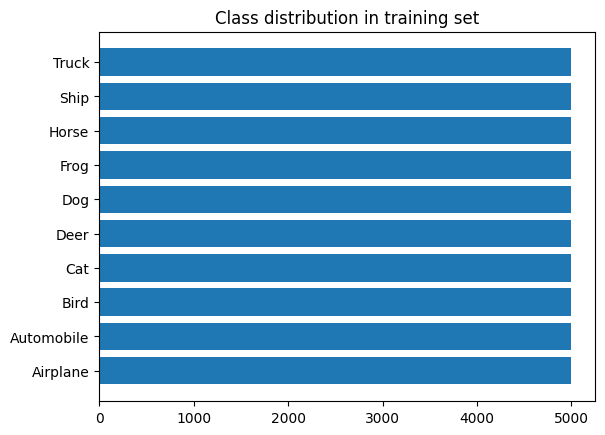

In [10]:
classes_name = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

classes, counts = np.unique(y_train, return_counts=True)
plt.barh(classes_name, counts)
plt.title('Class distribution in training set')

Text(0.5, 1.0, 'Class distribution in testing set')

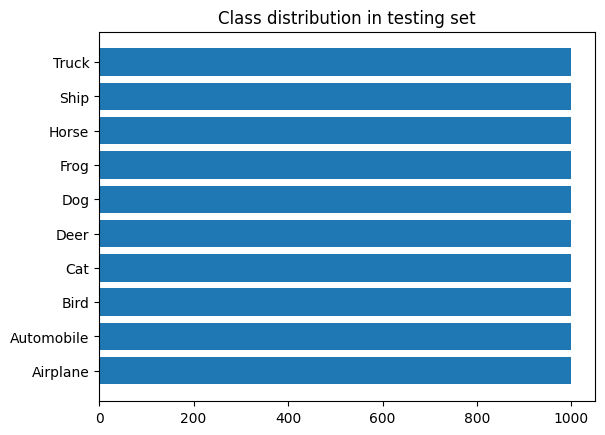

In [11]:
classes, counts = np.unique(y_test, return_counts=True)
plt.barh(classes_name, counts)
plt.title('Class distribution in testing set')

The class are equally distributed

# 🔄 Data Preprocessing

In [12]:
# Scale the data
#X_train = X_train / 255.0
#X_test = X_test / 255.0

# Transform target variable into one-hotencoding
y_cat_train = to_categorical(y_train, 10)
y_cat_test = to_categorical(y_test, 10)

In [13]:
y_cat_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

# 🤖 Model Building

In [14]:
INPUT_SHAPE = (32, 32, 1)
KERNEL_SIZE = (3, 3)
model = Sequential()

# Convolutional Layer
model.add(Conv2D(filters=32, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(BatchNormalization())
# Pooling layer
model.add(MaxPool2D(pool_size=(2, 2)))
# Dropout layers
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
# model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))

METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=METRICS)

/Users/santiagomunera/miniconda3/envs/ml/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,29

 Total params: 551,786 (2.10 MB)

 Trainable params: 550,890 (2.10 MB)

 Non-trainable params: 896 (3.50 KB)

## Early Stopping

In [17]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

## Data Augmentations

In [18]:
batch_size = 32
data_generator = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_generator = data_generator.flow(X_train, y_cat_train, batch_size)
steps_per_epoch = X_train.shape[0] // batch_size

r = model.fit(train_generator, 
              epochs=50,
              steps_per_epoch=steps_per_epoch,
              validation_data=(X_test, y_cat_test), 
#               callbacks=[early_stop],
#               batch_size=batch_size,
             )

Epoch 1/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 1:16:31 3s/step - accuracy: 0.0625 - loss: 3.9295 - precision: 0.0455 - recall: 0.0312

/Users/santiagomunera/miniconda3/envs/ml/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 151s 95ms/step - accuracy: 0.1943 - loss: 2.2316 - precision: 0.3145 - recall: 0.0111 - val_accuracy: 0.3112 - val_loss: 1.8949 - val_precision: 0.6037 - val_recall: 0.0163
Epoch 2/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 2:12 85ms/step - accuracy: 0.3438 - loss: 1.8831 - precision: 1.0000 - recall: 0.0312

2024-05-18 16:36:58.829690: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/santiagomunera/miniconda3/envs/ml/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.3438 - loss: 1.8831 - precision: 1.0000 - recall: 0.0312 - val_accuracy: 0.3097 - val_loss: 1.8947 - val_precision: 0.6154 - val_recall: 0.0160
Epoch 3/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 147s 94ms/step - accuracy: 0.2783 - loss: 1.9583 - precision: 0.5019 - recall: 0.0339 - val_accuracy: 0.3286 - val_loss: 1.8427 - val_precision: 0.5515 - val_recall: 0.0889
Epoch 4/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 2:16 87ms/step - accuracy: 0.3438 - loss: 2.0705 - precision: 0.4286 - recall: 0.0938

2024-05-18 16:39:33.044073: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.3438 - loss: 2.0705 - precision: 0.4286 - recall: 0.0938 - val_accuracy: 0.3305 - val_loss: 1.8474 - val_precision: 0.5596 - val_recall: 0.0883
Epoch 5/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 150s 96ms/step - accuracy: 0.3079 - loss: 1.8896 - precision: 0.5628 - recall: 0.0665 - val_accuracy: 0.3604 - val_loss: 1.7827 - val_precision: 0.6550 - val_recall: 0.0883
Epoch 6/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 2:13 85ms/step - accuracy: 0.2500 - loss: 1.7499 - precision: 0.2000 - recall: 0.0312

2024-05-18 16:42:10.298309: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.2500 - loss: 1.7499 - precision: 0.2000 - recall: 0.0312 - val_accuracy: 0.3612 - val_loss: 1.7864 - val_precision: 0.6574 - val_recall: 0.0873
Epoch 7/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 150s 96ms/step - accuracy: 0.3252 - loss: 1.8556 - precision: 0.5743 - recall: 0.0814 - val_accuracy: 0.3999 - val_loss: 1.6907 - val_precision: 0.6771 - val_recall: 0.0973
Epoch 8/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 2:19 89ms/step - accuracy: 0.4062 - loss: 1.7805 - precision: 1.0000 - recall: 0.1250

2024-05-18 16:44:47.982591: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.4062 - loss: 1.7805 - precision: 1.0000 - recall: 0.1250 - val_accuracy: 0.4027 - val_loss: 1.6873 - val_precision: 0.6765 - val_recall: 0.1006
Epoch 9/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 150s 96ms/step - accuracy: 0.3399 - loss: 1.8228 - precision: 0.5833 - recall: 0.0985 - val_accuracy: 0.4068 - val_loss: 1.6585 - val_precision: 0.7064 - val_recall: 0.1287
Epoch 10/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 3:16 126ms/step - accuracy: 0.4375 - loss: 1.6681 - precision: 0.5714 - recall: 0.1250

2024-05-18 16:47:25.405568: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.4375 - loss: 1.6681 - precision: 0.5714 - recall: 0.1250 - val_accuracy: 0.4063 - val_loss: 1.6589 - val_precision: 0.7104 - val_recall: 0.1268
Epoch 11/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 153s 98ms/step - accuracy: 0.3546 - loss: 1.7798 - precision: 0.6090 - recall: 0.1159 - val_accuracy: 0.4224 - val_loss: 1.6259 - val_precision: 0.6903 - val_recall: 0.1596
Epoch 12/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 2:39 102ms/step - accuracy: 0.3750 - loss: 1.6471 - precision: 0.5000 - recall: 0.1250

2024-05-18 16:50:05.734329: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.3750 - loss: 1.6471 - precision: 0.5000 - recall: 0.1250 - val_accuracy: 0.4223 - val_loss: 1.6244 - val_precision: 0.6929 - val_recall: 0.1584
Epoch 13/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 151s 97ms/step - accuracy: 0.3674 - loss: 1.7520 - precision: 0.6279 - recall: 0.1346 - val_accuracy: 0.4305 - val_loss: 1.5976 - val_precision: 0.7257 - val_recall: 0.1540
Epoch 14/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 2:32 98ms/step - accuracy: 0.4688 - loss: 1.4719 - precision: 1.0000 - recall: 0.2812

2024-05-18 16:52:44.475699: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.4688 - loss: 1.4719 - precision: 1.0000 - recall: 0.2812 - val_accuracy: 0.4289 - val_loss: 1.6013 - val_precision: 0.7224 - val_recall: 0.1517
Epoch 15/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 151s 97ms/step - accuracy: 0.3840 - loss: 1.7234 - precision: 0.6200 - recall: 0.1452 - val_accuracy: 0.4303 - val_loss: 1.6159 - val_precision: 0.6479 - val_recall: 0.2026
Epoch 16/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 2:34 99ms/step - accuracy: 0.4062 - loss: 1.6101 - precision: 0.8750 - recall: 0.2188

2024-05-18 16:55:23.635660: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.4062 - loss: 1.6101 - precision: 0.8750 - recall: 0.2188 - val_accuracy: 0.4294 - val_loss: 1.6136 - val_precision: 0.6532 - val_recall: 0.1998
Epoch 17/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 221s 142ms/step - accuracy: 0.3866 - loss: 1.7151 - precision: 0.6240 - recall: 0.1506 - val_accuracy: 0.4455 - val_loss: 1.5793 - val_precision: 0.6521 - val_recall: 0.2463
Epoch 18/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 3:10 122ms/step - accuracy: 0.5000 - loss: 1.6365 - precision: 0.7143 - recall: 0.1562

2024-05-18 16:59:12.295434: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.5000 - loss: 1.6365 - precision: 0.7143 - recall: 0.1562 - val_accuracy: 0.4469 - val_loss: 1.5786 - val_precision: 0.6484 - val_recall: 0.2484
Epoch 19/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 154s 98ms/step - accuracy: 0.3958 - loss: 1.6985 - precision: 0.6253 - recall: 0.1615 - val_accuracy: 0.4487 - val_loss: 1.5577 - val_precision: 0.6982 - val_recall: 0.2182
Epoch 20/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 2:52 110ms/step - accuracy: 0.4062 - loss: 1.7192 - precision: 0.6667 - recall: 0.1250

2024-05-18 17:01:53.931535: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.4062 - loss: 1.7192 - precision: 0.6667 - recall: 0.1250 - val_accuracy: 0.4475 - val_loss: 1.5594 - val_precision: 0.6946 - val_recall: 0.2177
Epoch 21/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 148s 95ms/step - accuracy: 0.4032 - loss: 1.6691 - precision: 0.6442 - recall: 0.1728 - val_accuracy: 0.4516 - val_loss: 1.5414 - val_precision: 0.6851 - val_recall: 0.2278
Epoch 22/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 3:04 118ms/step - accuracy: 0.3750 - loss: 1.6525 - precision: 0.5000 - recall: 0.1562

2024-05-18 17:04:28.880594: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.3750 - loss: 1.6525 - precision: 0.5000 - recall: 0.1562 - val_accuracy: 0.4517 - val_loss: 1.5396 - val_precision: 0.6888 - val_recall: 0.2284
Epoch 23/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 146s 94ms/step - accuracy: 0.4108 - loss: 1.6544 - precision: 0.6519 - recall: 0.1837 - val_accuracy: 0.4646 - val_loss: 1.5223 - val_precision: 0.6974 - val_recall: 0.2431
Epoch 24/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 2:50 109ms/step - accuracy: 0.4688 - loss: 1.6141 - precision: 0.6364 - recall: 0.2188

2024-05-18 17:07:02.340746: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.4688 - loss: 1.6141 - precision: 0.6364 - recall: 0.2188 - val_accuracy: 0.4638 - val_loss: 1.5232 - val_precision: 0.6991 - val_recall: 0.2419
Epoch 25/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 152s 97ms/step - accuracy: 0.4183 - loss: 1.6325 - precision: 0.6606 - recall: 0.1923 - val_accuracy: 0.4566 - val_loss: 1.5279 - val_precision: 0.6771 - val_recall: 0.2344
Epoch 26/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 4:51 187ms/step - accuracy: 0.4688 - loss: 1.5983 - precision: 0.6667 - recall: 0.1875

2024-05-18 17:09:41.673459: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.4688 - loss: 1.5983 - precision: 0.6667 - recall: 0.1875 - val_accuracy: 0.4580 - val_loss: 1.5261 - val_precision: 0.6779 - val_recall: 0.2357
Epoch 27/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 147s 94ms/step - accuracy: 0.4260 - loss: 1.6150 - precision: 0.6623 - recall: 0.2006 - val_accuracy: 0.4669 - val_loss: 1.5059 - val_precision: 0.6972 - val_recall: 0.2519
Epoch 28/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 2:45 106ms/step - accuracy: 0.2812 - loss: 1.6587 - precision: 0.5000 - recall: 0.1562

2024-05-18 17:12:15.347930: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.2812 - loss: 1.6587 - precision: 0.5000 - recall: 0.1562 - val_accuracy: 0.4670 - val_loss: 1.5058 - val_precision: 0.6946 - val_recall: 0.2545
Epoch 29/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 145s 93ms/step - accuracy: 0.4325 - loss: 1.5970 - precision: 0.6672 - recall: 0.2087 - val_accuracy: 0.4756 - val_loss: 1.4943 - val_precision: 0.7043 - val_recall: 0.2568
Epoch 30/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 2:44 105ms/step - accuracy: 0.6250 - loss: 1.3507 - precision: 0.7273 - recall: 0.2500

2024-05-18 17:14:47.263176: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6250 - loss: 1.3507 - precision: 0.7273 - recall: 0.2500 - val_accuracy: 0.4756 - val_loss: 1.4949 - val_precision: 0.7068 - val_recall: 0.2548
Epoch 31/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 148s 95ms/step - accuracy: 0.4363 - loss: 1.5891 - precision: 0.6660 - recall: 0.2132 - val_accuracy: 0.4814 - val_loss: 1.4936 - val_precision: 0.7156 - val_recall: 0.2436
Epoch 32/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 2:38 101ms/step - accuracy: 0.4062 - loss: 1.5536 - precision: 0.6667 - recall: 0.1250

2024-05-18 17:17:22.456185: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.4062 - loss: 1.5536 - precision: 0.6667 - recall: 0.1250 - val_accuracy: 0.4810 - val_loss: 1.4918 - val_precision: 0.7167 - val_recall: 0.2441
Epoch 33/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 148s 95ms/step - accuracy: 0.4414 - loss: 1.5786 - precision: 0.6675 - recall: 0.2164 - val_accuracy: 0.4747 - val_loss: 1.5057 - val_precision: 0.7091 - val_recall: 0.2467
Epoch 34/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 3:07 120ms/step - accuracy: 0.4688 - loss: 1.5453 - precision: 0.7143 - recall: 0.3125

2024-05-18 17:19:58.445910: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.4688 - loss: 1.5453 - precision: 0.7143 - recall: 0.3125 - val_accuracy: 0.4727 - val_loss: 1.5110 - val_precision: 0.7084 - val_recall: 0.2444
Epoch 35/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 149s 95ms/step - accuracy: 0.4500 - loss: 1.5522 - precision: 0.6769 - recall: 0.2253 - val_accuracy: 0.4859 - val_loss: 1.4667 - val_precision: 0.7224 - val_recall: 0.2514
Epoch 36/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 3:07 120ms/step - accuracy: 0.5312 - loss: 1.4289 - precision: 0.9286 - recall: 0.4062

2024-05-18 17:22:34.346184: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5312 - loss: 1.4289 - precision: 0.9286 - recall: 0.4062 - val_accuracy: 0.4844 - val_loss: 1.4665 - val_precision: 0.7228 - val_recall: 0.2529
Epoch 37/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 150s 96ms/step - accuracy: 0.4584 - loss: 1.5385 - precision: 0.6883 - recall: 0.2387 - val_accuracy: 0.5068 - val_loss: 1.4328 - val_precision: 0.7285 - val_recall: 0.2753
Epoch 38/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 2:46 107ms/step - accuracy: 0.3125 - loss: 1.8242 - precision: 0.6000 - recall: 0.1875

2024-05-18 17:25:11.743919: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.3125 - loss: 1.8242 - precision: 0.6000 - recall: 0.1875 - val_accuracy: 0.5060 - val_loss: 1.4314 - val_precision: 0.7330 - val_recall: 0.2748
Epoch 39/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 147s 94ms/step - accuracy: 0.4667 - loss: 1.5128 - precision: 0.6890 - recall: 0.2469 - val_accuracy: 0.4985 - val_loss: 1.4362 - val_precision: 0.7191 - val_recall: 0.2854
Epoch 40/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 2:38 101ms/step - accuracy: 0.5312 - loss: 1.3448 - precision: 0.7222 - recall: 0.4062

2024-05-18 17:27:46.710235: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5312 - loss: 1.3448 - precision: 0.7222 - recall: 0.4062 - val_accuracy: 0.4983 - val_loss: 1.4366 - val_precision: 0.7186 - val_recall: 0.2865
Epoch 41/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 145s 93ms/step - accuracy: 0.4625 - loss: 1.5133 - precision: 0.6864 - recall: 0.2523 - val_accuracy: 0.4993 - val_loss: 1.4290 - val_precision: 0.7316 - val_recall: 0.2796
Epoch 42/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 2:40 103ms/step - accuracy: 0.5000 - loss: 1.5316 - precision: 0.5714 - recall: 0.1250

2024-05-18 17:30:19.463412: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.5000 - loss: 1.5316 - precision: 0.5714 - recall: 0.1250 - val_accuracy: 0.4995 - val_loss: 1.4301 - val_precision: 0.7321 - val_recall: 0.2788
Epoch 43/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 148s 95ms/step - accuracy: 0.4660 - loss: 1.5019 - precision: 0.6931 - recall: 0.2512 - val_accuracy: 0.5052 - val_loss: 1.4198 - val_precision: 0.7129 - val_recall: 0.3025
Epoch 44/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 2:37 101ms/step - accuracy: 0.3750 - loss: 1.7076 - precision: 0.4545 - recall: 0.1562

2024-05-18 17:32:54.994880: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.3750 - loss: 1.7076 - precision: 0.4545 - recall: 0.1562 - val_accuracy: 0.5046 - val_loss: 1.4206 - val_precision: 0.7145 - val_recall: 0.3040
Epoch 45/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 151s 96ms/step - accuracy: 0.4684 - loss: 1.5063 - precision: 0.6884 - recall: 0.2534 - val_accuracy: 0.5018 - val_loss: 1.4261 - val_precision: 0.7213 - val_recall: 0.2836
Epoch 46/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 2:56 113ms/step - accuracy: 0.4375 - loss: 1.4774 - precision: 0.6667 - recall: 0.1875

2024-05-18 17:35:32.809545: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.4375 - loss: 1.4774 - precision: 0.6667 - recall: 0.1875 - val_accuracy: 0.5009 - val_loss: 1.4265 - val_precision: 0.7219 - val_recall: 0.2835
Epoch 47/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 149s 95ms/step - accuracy: 0.4752 - loss: 1.4837 - precision: 0.7014 - recall: 0.2663 - val_accuracy: 0.4975 - val_loss: 1.4222 - val_precision: 0.7230 - val_recall: 0.2889
Epoch 48/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 2:46 107ms/step - accuracy: 0.6250 - loss: 1.1384 - precision: 0.7692 - recall: 0.3125

2024-05-18 17:38:08.791129: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6250 - loss: 1.1384 - precision: 0.7692 - recall: 0.3125 - val_accuracy: 0.4956 - val_loss: 1.4242 - val_precision: 0.7219 - val_recall: 0.2882
Epoch 49/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 149s 95ms/step - accuracy: 0.4761 - loss: 1.4847 - precision: 0.6991 - recall: 0.2644 - val_accuracy: 0.5083 - val_loss: 1.4160 - val_precision: 0.7054 - val_recall: 0.3220
Epoch 50/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 2:51 110ms/step - accuracy: 0.5000 - loss: 1.6485 - precision: 0.6250 - recall: 0.3125

2024-05-18 17:40:45.259278: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5000 - loss: 1.6485 - precision: 0.6250 - recall: 0.3125 - val_accuracy: 0.5081 - val_loss: 1.4190 - val_precision: 0.7048 - val_recall: 0.3214


# 📊 Model Evaluation

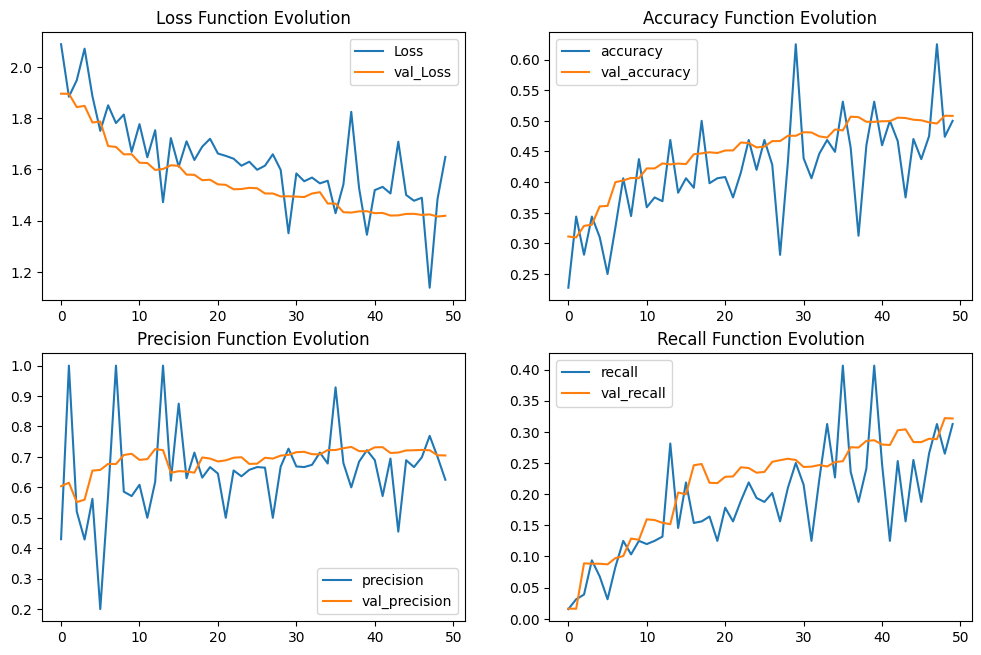

In [19]:
plt.figure(figsize=(12, 16))

plt.subplot(4, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='val_Loss')
plt.title('Loss Function Evolution')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy Function Evolution')
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(r.history['precision'], label='precision')
plt.plot(r.history['val_precision'], label='val_precision')
plt.title('Precision Function Evolution')
plt.legend()

plt.subplot(4, 2, 4)
plt.plot(r.history['recall'], label='recall')
plt.plot(r.history['val_recall'], label='val_recall')
plt.title('Recall Function Evolution')
plt.legend()

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.5074 - loss: 1.4152 - precision: 0.7122 - recall: 0.3252
Test Accuracy : 50.81%
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step


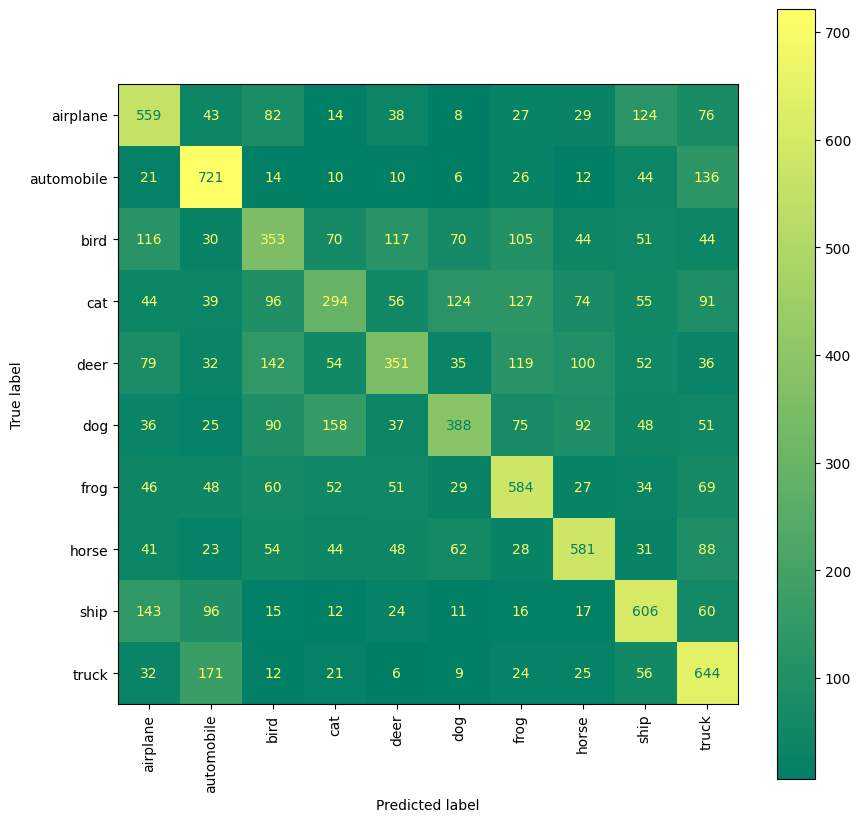

In [20]:
evaluation = model.evaluate(X_test, y_cat_test)
print(f'Test Accuracy : {evaluation[1] * 100:.2f}%')

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred)


disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)


# NOTE: Fill all variables here with default values of the plot_confusion_matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax,cmap='summer')

plt.show()

In [21]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.56      0.53      1000
           1       0.59      0.72      0.65      1000
           2       0.38      0.35      0.37      1000
           3       0.40      0.29      0.34      1000
           4       0.48      0.35      0.40      1000
           5       0.52      0.39      0.45      1000
           6       0.52      0.58      0.55      1000
           7       0.58      0.58      0.58      1000
           8       0.55      0.61      0.58      1000
           9       0.50      0.64      0.56      1000

    accuracy                           0.51     10000
   macro avg       0.50      0.51      0.50     10000
weighted avg       0.50      0.51      0.50     10000



## Test on one image

 Image 100 is 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
The model predict that image 100 is 2


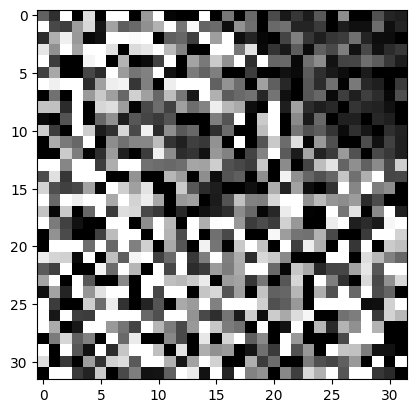

In [22]:
my_image = X_test[100]
plt.imshow(my_image, cmap='gray')

# that's a Deer
print(f" Image 100 is {y_test[100]}")

# correctly predicted as a Deer
pred_100 = np.argmax(model.predict(my_image.reshape(1, 32, 32, 1)))
print(f"The model predict that image 100 is {pred_100}")

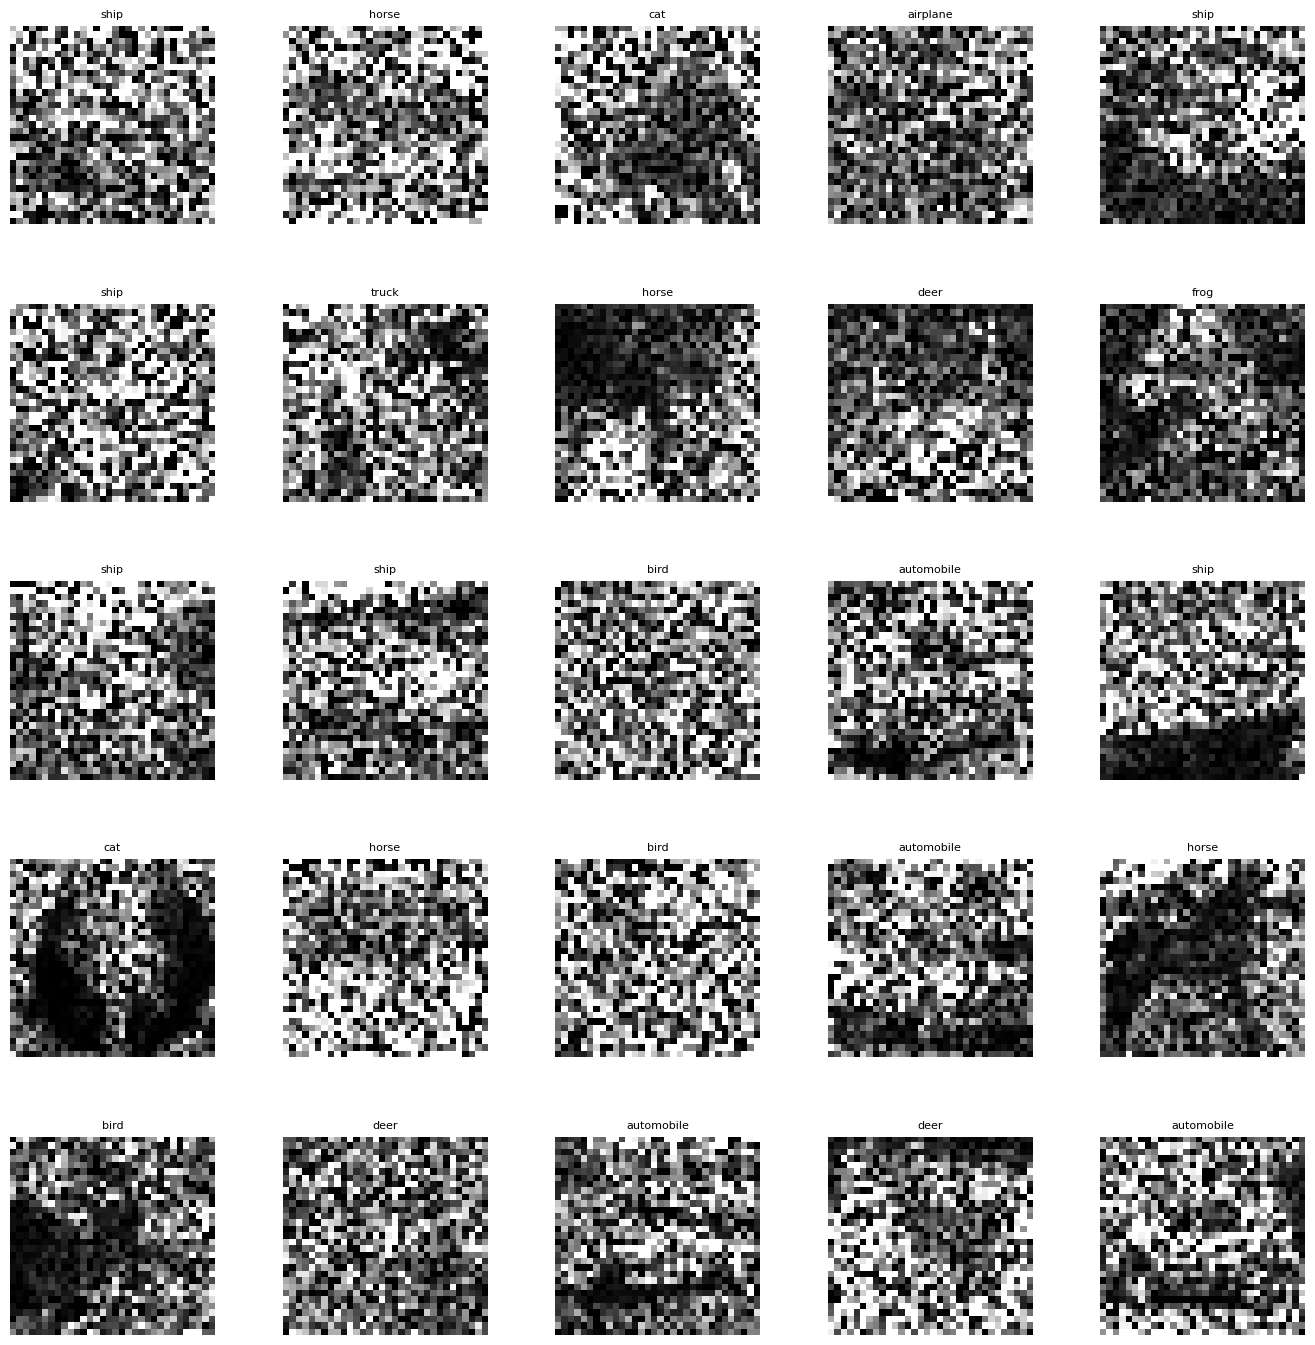

In [23]:
# Define the labels of the dataset
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
          'dog', 'frog', 'horse', 'ship', 'truck']

# Let's view more images in a grid format
# Define the dimensions of the plot grid 
W_grid = 5
L_grid = 5

# fig, axes = plt.subplots(L_grid, W_grid)
# subplot return the figure object and axes object
# we can use the axes object to plot specific figures at various locations

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))

axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array

n_test = len(X_test) # get the length of the train dataset

# Select a random number from 0 to n_train
for i in np.arange(0, W_grid * L_grid): # create evenly spaces variables 

    # Select a random number
    index = np.random.randint(0, n_test)
    # read and display an image with the selected index    
    axes[i].imshow(X_test[index,1:], cmap='gray')
    label_index = int(y_pred[index])
    axes[i].set_title(labels[label_index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

In [24]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel(f"{labels[int(predicted_label)]} {100*np.max(predictions_array):2.0f}% ({labels[int(true_label)]})", 
               color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, int(true_label[i])
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step


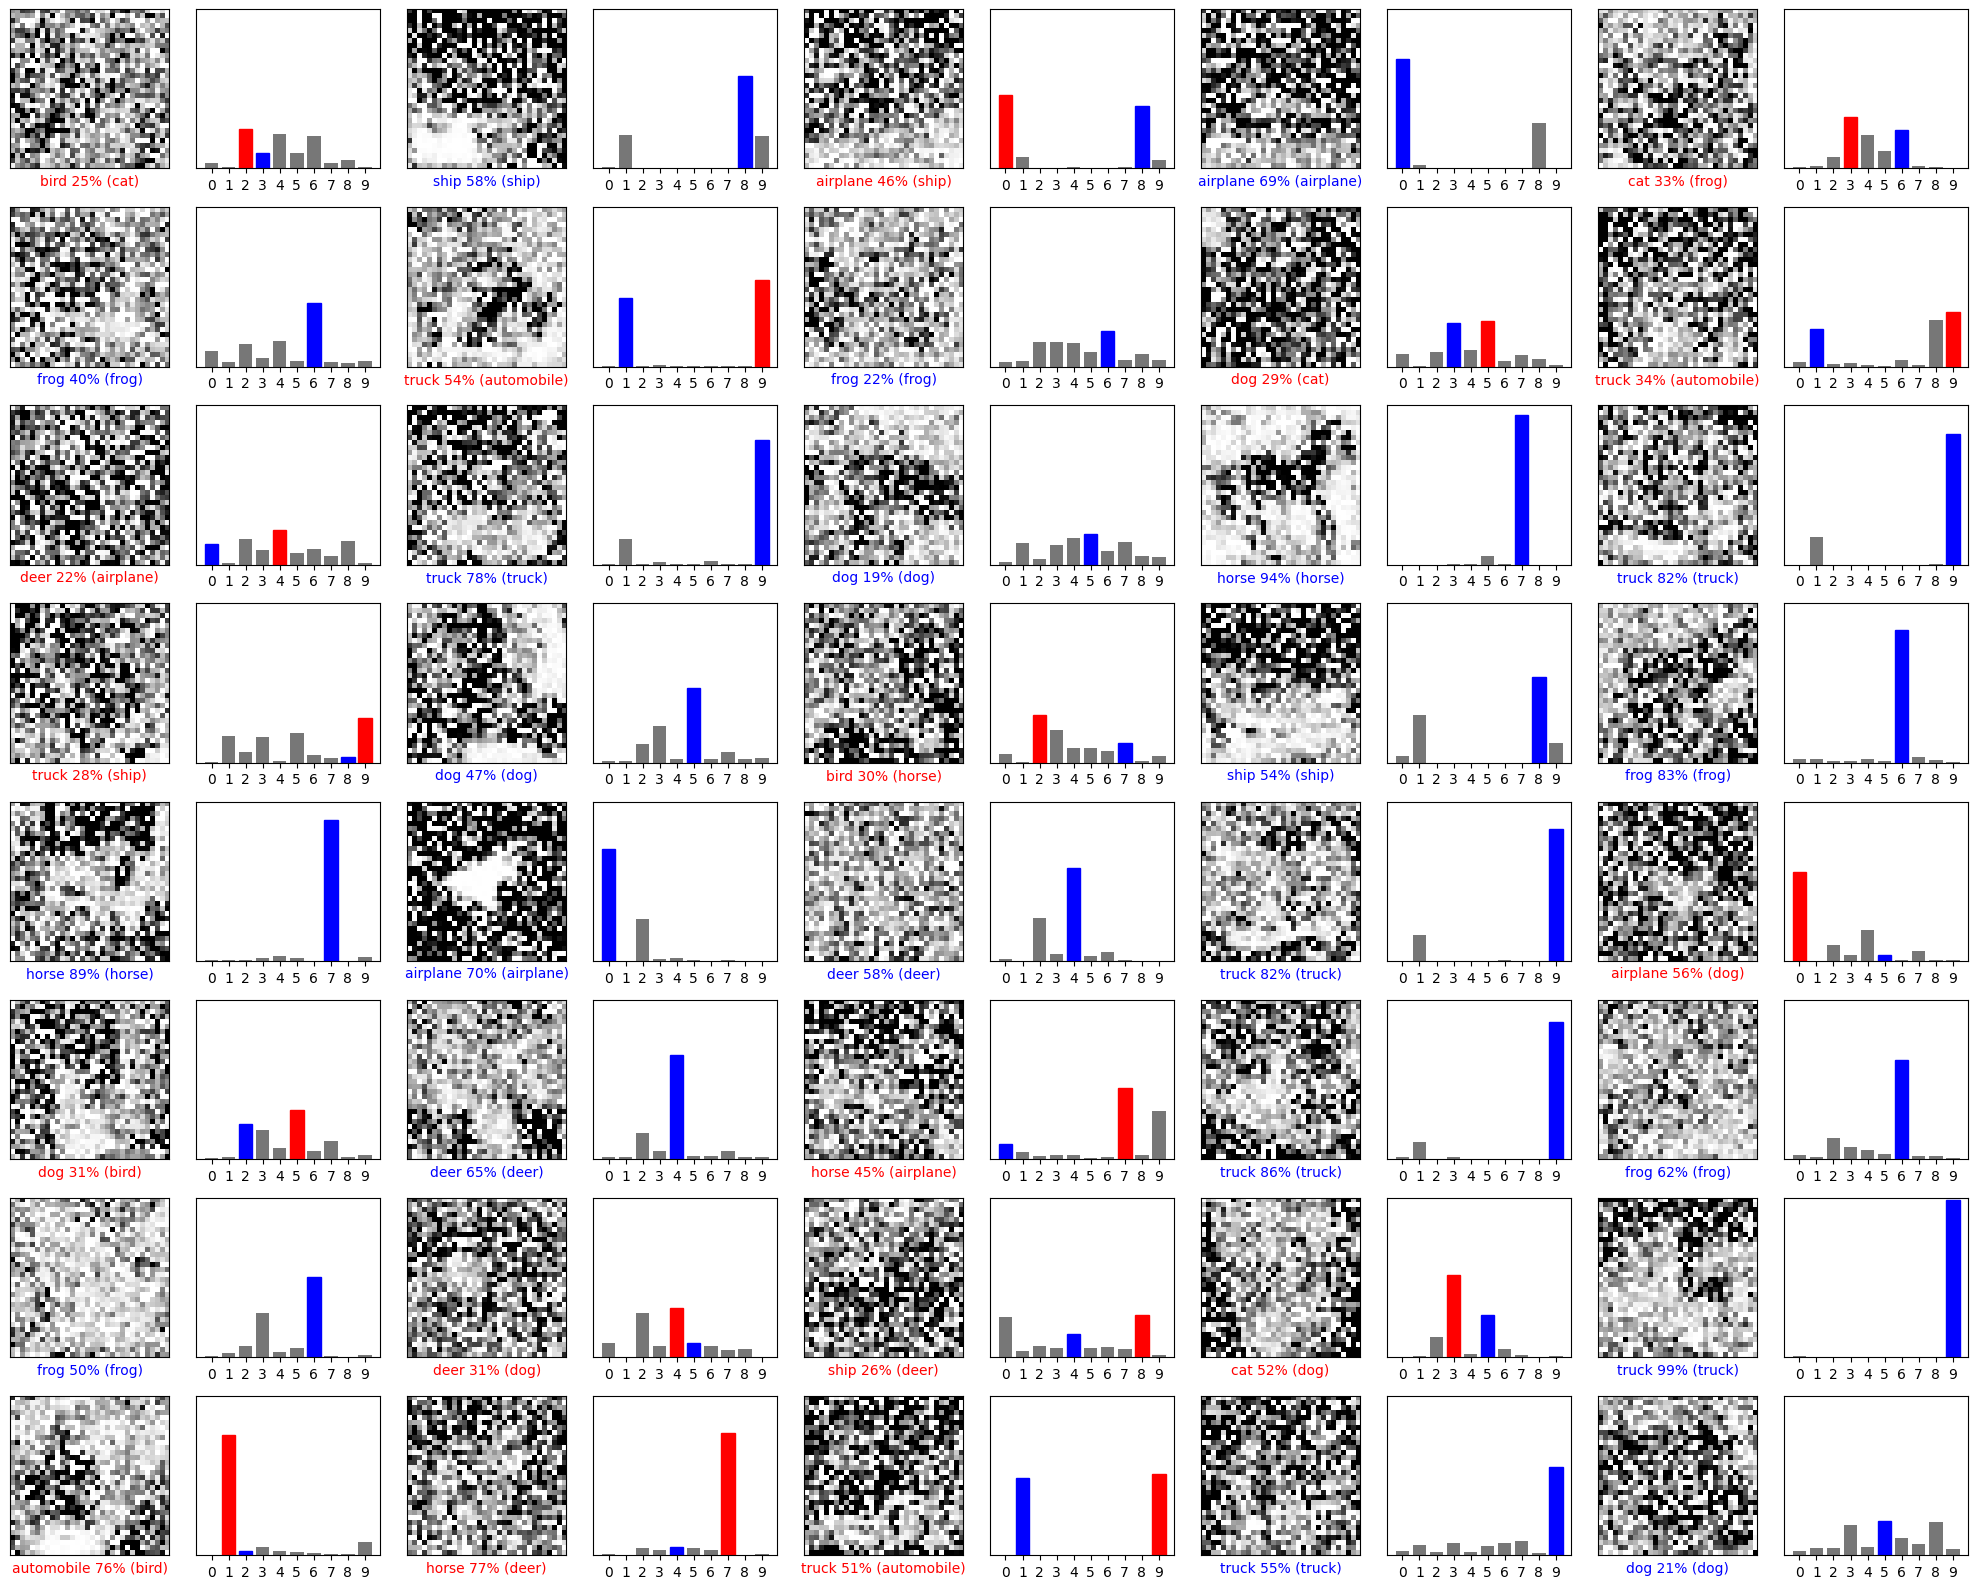

In [25]:
predictions = model.predict(X_test)

# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 8
num_cols = 5
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_image(i, predictions[i], y_test, X_test)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], y_test)
plt.tight_layout()
plt.show()